In [43]:
## 数据工具包
import numpy as np
import pandas as pd
from tqdm import tqdm

import warnings
warnings.filterwarnings('ignore')

import os 
import gc
import time
import datetime

import multiprocessing as mp
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
plt.rcParams['font.sans-serif']=['SimHei']   # 用来正常显示中文标签
plt.rcParams['axes.unicode_minus']=False     # 用来正常显示负号
matplotlib.rc("font",family='Heiti TC')
%matplotlib inline

In [44]:
from google.colab import drive
drive.mount('/content/drive')
from google.colab import drive
import os
path = "/content/drive/MyDrive/数据科学项目/DAU-predict"
os.chdir(path)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### 数据获取和预处理

In [45]:
register = pd.read_csv('user_register_log.txt',sep='\t',names=['user_id','register_day','register_type','device_type'])#注册表
launch = pd.read_csv('app_launch_log.txt',sep='\t',names=['user_id','launch_day'])#启动日志
create = pd.read_csv('video_create_log.txt',sep='\t',names=['user_id','create_day'])#拍摄日志
activity = pd.read_csv('user_activity_log.txt',sep='\t',names=['user_id','act_day','page','video_id','author_id','act_type'])#行为日志

**注册信息**

In [46]:
register.head()

,user_id,register_day,register_type,device_type
0,744025,1,1,283
1,1270299,1,1,259
2,571220,1,1,2
3,1308501,1,0,23
4,745554,1,2,0


启动日志

In [47]:
launch.head()

,user_id,launch_day
0,383135,1
1,330986,4
2,330986,9
3,330986,11
4,330986,12


In [48]:
create.head()

,user_id,create_day
0,720497,1
1,720497,1
2,720497,1
3,1075211,6
4,1075211,12


In [49]:
activity.head()

,user_id,act_day,page,video_id,author_id,act_type
0,1062323,22,3,2877472,880271,0
1,639898,17,3,740662,210200,0
2,1260200,5,3,3332414,162866,0
3,817201,22,3,1129617,530246,0
4,817201,23,3,1129617,530246,0


### 用户行为数据分析和可视化

#### register表

In [50]:
register.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51709 entries, 0 to 51708
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype
---  ------         --------------  -----
 0   user_id        51709 non-null  int64
 1   register_day   51709 non-null  int64
 2   register_type  51709 non-null  int64
 3   device_type    51709 non-null  int64
dtypes: int64(4)
memory usage: 1.6 MB


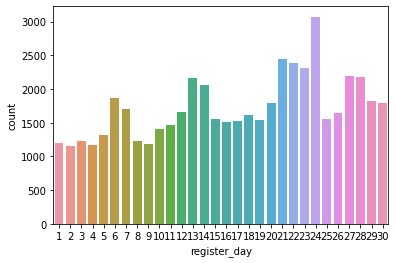

In [51]:
sns.countplot(x='register_day',data=register)  #可以看出24号这天的数据显著增多

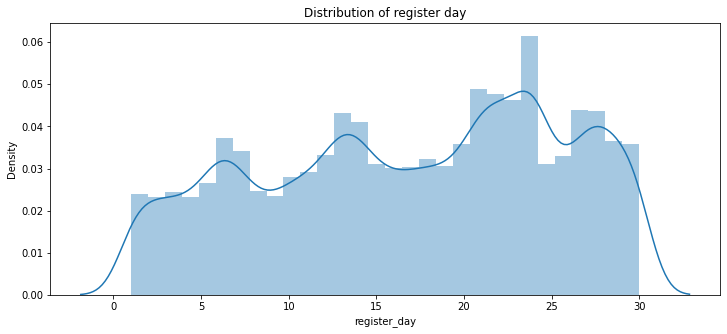

In [52]:
plt.figure(figsize=(12,5))
plt.title("Distribution of register day")
ax = sns.distplot(register["register_day"],bins=30)

可以看出24号这天，注册的人数特别多，有一个异常的峰值，因此我们来看看这一天具体的注册情况

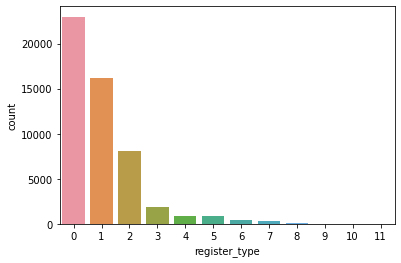

In [53]:
sns.countplot(x='register_type',data=register)

整体的注册类型是降序的，下面我们看24号这一天的情况。

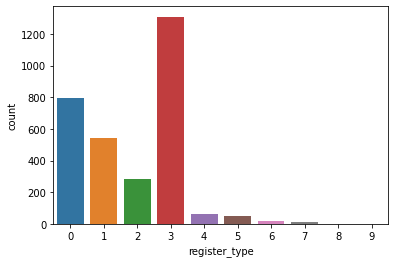

In [54]:
sns.countplot(x='register_type',data=register[register['register_day']==24])

发现24号这一天，注册类型3特别多。这说明

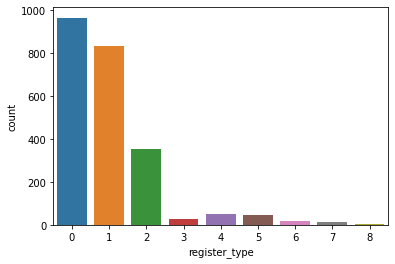

In [55]:
sns.countplot(x='register_type',data=register[register['register_day']==23])

In [56]:
register['device_type'].value_counts()

0        2366
2        1656
4        1435
7        1248
8        1237
         ... 
22422       1
3836        1
10566       1
7203        1
1798        1
Name: device_type, Length: 3592, dtype: int64

#### launch表

In [57]:
launch.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 251943 entries, 0 to 251942
Data columns (total 2 columns):
 #   Column      Non-Null Count   Dtype
---  ------      --------------   -----
 0   user_id     251943 non-null  int64
 1   launch_day  251943 non-null  int64
dtypes: int64(2)
memory usage: 3.8 MB


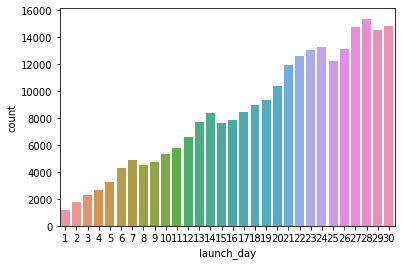

In [58]:
sns.countplot(x='launch_day',data=launch)

In [59]:
launch['user_id'].value_counts()

1367044    30
819809     30
1111790    30
1313815    30
517425     30
           ..
1076720     1
810680      1
1257427     1
36946       1
741669      1
Name: user_id, Length: 51709, dtype: int64

#### create表

In [60]:
create.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35151 entries, 0 to 35150
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   user_id     35151 non-null  int64
 1   create_day  35151 non-null  int64
dtypes: int64(2)
memory usage: 549.4 KB


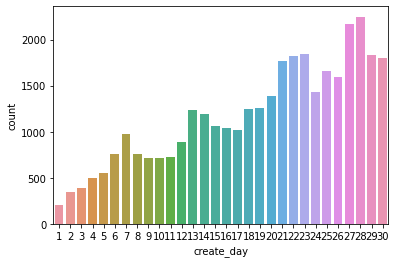

In [61]:
sns.countplot(x='create_day',data=create)

#### activity表

In [62]:
activity.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20607228 entries, 0 to 20607227
Data columns (total 6 columns):
 #   Column     Dtype
---  ------     -----
 0   user_id    int64
 1   act_day    int64
 2   page       int64
 3   video_id   int64
 4   author_id  int64
 5   act_type   int64
dtypes: int64(6)
memory usage: 943.3 MB


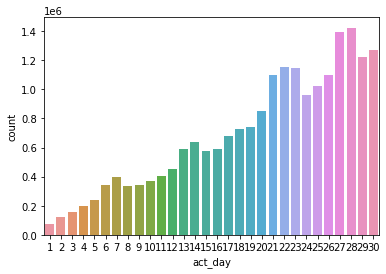

In [63]:
sns.countplot(x='act_day',data=activity)

# 滑窗法扩充训练集数据

In [64]:
def split_data(data, columns, start_day, end_day):
    data = data[(data[columns] >= start_day) & (data[columns] <= end_day)]
    return data 

'''
下面返回的list说明下：
以1-18天为起始特征区间，用于返回需要划多少天
例如划1-18，就返回18-18=0，
划测试集1-30，就返回30-18=12
需要少划几个对应修改就好
... 要修改起始特征区间，修改下面的 ups 和 downs 函数
''' 
def features_addday_list():
    return [0, 1, 2, 3, 4, 5,12]

def ups():
    return 1

def downs():
    return 18

In [65]:
def get_label_list(start_day, end_day):
    result = split_data(launch, 'launch_day', start_day, end_day)['user_id'].drop_duplicates()
    return pd.Series(result)

up = downs()+1
down = downs()+7
data = register.loc[:, ['user_id']]
for label_num in range(len(features_addday_list())-1):
    print(label_num, up + label_num, down + label_num)
    label_list = get_label_list(up + label_num, down + label_num)
    label_name = 'label_' + str(label_num)
    data[label_name] = data['user_id'].isin(label_list).replace({True: 1, False: 0})
data.to_csv('./feature/data_label.csv', index=None)

0 19 25
1 20 26
2 21 27
3 22 28
4 23 29
5 24 30


# 特征工程

## register相关特征

In [66]:
up = ups()
down = downs()
for feature_num in tqdm(features_addday_list()):

    # 基础变量定义
    feature_start = up + 0
    feature_end = down + feature_num
    print(feature_num, feature_start, feature_end)

    '''
    result_data 是存放特征的结果文件
    feature_data 用于存放被提取的原文件
    *****_tmp  存放临时特征文件
    '''
    result_data = split_data(register, 'register_day', 1, feature_end)
    feature_data = split_data(register, 'register_day', feature_start, feature_end)

    # 提特征(已经包含设备类型、设备类型)
    # 特征区间最大天数减去注册日期
    result_data['maxday_red_registerday'] = max(feature_data['register_day']) - feature_data['register_day']
    result_data = result_data.fillna(max(feature_data['register_day']))
    del result_data['register_day']

    # 保存结果
    result_file_name = 'register_feature_'+str(feature_num)+'.csv'
    result_data.to_csv('./feature/'+result_file_name, index=None)

 14%|█▍        | 1/7 [00:00<00:00,  8.85it/s]

0 1 18
1 1 19


 43%|████▎     | 3/7 [00:00<00:00, 10.55it/s]

2 1 20
3 1 21
4 1 22


 71%|███████▏  | 5/7 [00:00<00:00, 11.09it/s]

5 1 23
12 1 30


100%|██████████| 7/7 [00:00<00:00, 10.27it/s]


## create相关特征

In [67]:
up = ups()
down = downs()

for feature_num in tqdm(features_addday_list()):
    
    # 基础变量定义
    feature_start = up
    feature_end = down + feature_num
    print(feature_num, feature_start, feature_end)
    
    result_data = split_data(register, 'register_day', 1, feature_end).loc[:, ['user_id', 'register_day']]
    feature_data = split_data(create, 'create_day', feature_start, feature_end)

    # 提特征
    # 用户创建视频计数
    feature_tmp = pd.pivot_table(feature_data, index='user_id', values='create_day',
                                 aggfunc='count').reset_index().rename(columns={"create_day": 'create_count'})
    result_data = pd.merge(result_data, feature_tmp, on='user_id', how='left')
    result_data = result_data.fillna(0)

    # 用户创建视频的 平均/最大/最小日期 与 注册日期/最大时间 的时间差
    feature_tmp = pd.pivot_table(feature_data, index='user_id', values='create_day',
                                 aggfunc='mean').reset_index().rename(columns={"create_day": 'create_mean'})
    result_data = pd.merge(result_data, feature_tmp, on='user_id', how='left')
    result_data['createmean_red_register'] = result_data['create_mean'] - result_data['register_day']
    result_data['maxday_red_createmean'] = max(result_data['register_day']) - result_data['create_mean']

    feature_tmp = pd.pivot_table(feature_data, index='user_id', values='create_day',
                                 aggfunc=np.max).reset_index().rename(columns={"create_day": 'create_max'})
    result_data = pd.merge(result_data, feature_tmp, on='user_id', how='left')
    result_data['createmax_red_register'] = result_data['create_max'] - result_data['register_day']
    result_data['maxday_red_createmax'] = max(result_data['register_day']) - result_data['create_max']

    feature_tmp = pd.pivot_table(feature_data, index='user_id', values='create_day',
                                 aggfunc=np.min).reset_index().rename(columns={"create_day": 'create_min'})
    result_data = pd.merge(result_data, feature_tmp, on='user_id', how='left')
    result_data['createmin_red_register'] = result_data['create_min'] - result_data['register_day']
    result_data['maxday_red_createmin'] = max(result_data['register_day']) - result_data['create_min']
    result_data = result_data.fillna(-1)

    # 创建最大间隔
    result_data['max_red_min_create'] = result_data['create_max'] - result_data['create_min']

    # 最后一天是否有活动
    result_data['create_at_lastday'] = pd.Series(
        result_data['create_max'] == max(feature_data['create_day'])).replace({True: 1, False: 0})

    # 均值/最大/最小 天数处理
    result_data['create_mean'] = max(feature_data['create_day']) - result_data['create_mean']
    result_data['create_max'] = max(feature_data['create_day']) - result_data['create_max']
    result_data['create_min'] = max(feature_data['create_day']) - result_data['create_min']

    # 间隔的 方差/均值
    feature_data_tmp = feature_data.drop_duplicates(['user_id', 'create_day']).sort_values(
        by=['user_id', 'create_day'])
    feature_data_tmp['create_gap'] = np.array(feature_data_tmp['create_day']) - np.array(
        feature_data_tmp.tail(1).append(feature_data_tmp.head(len(feature_data_tmp) - 1))['create_day'])

    feature_tmp = pd.pivot_table(feature_data_tmp, index='user_id', values='create_gap',
                                 aggfunc=(lambda a: np.average(a[1:]))).reset_index().rename(
        columns={"create_gap": 'create_gap_mean'})
    result_data = pd.merge(result_data, feature_tmp, on='user_id', how='left')
    feature_tmp = pd.pivot_table(feature_data_tmp, index='user_id', values='create_gap',
                                 aggfunc=(lambda a: np.var(a[1:]))).reset_index().rename(
        columns={"create_gap": 'create_gap_var'})
    result_data = pd.merge(result_data, feature_tmp, on='user_id', how='left')
    result_data = result_data.fillna(0)

    # 是否一直连续/连续到结束
    result_data['always_create'] = [1 if i == 1 else 0 for i in result_data['create_gap_mean']]
    tmp = (result_data['create_at_lastday'] == 1).replace({True: 1, False: 0})
    result_data['always_create_atlast'] = tmp * result_data['always_create']
    del tmp

    # 创建日期的 方差/峰度/偏度
    feature_tmp = pd.pivot_table(feature_data, index='user_id', values='create_day',
                                 aggfunc=np.var).reset_index().rename(columns={"create_day": 'create_var'})
    result_data = pd.merge(result_data, feature_tmp, on='user_id', how='left')
    feature_tmp = pd.pivot_table(feature_data, index='user_id', values='create_day',
                                 aggfunc=pd.Series.kurt).reset_index().rename(columns={"create_day": 'create_kurt'})
    result_data = pd.merge(result_data, feature_tmp, on='user_id', how='left')
    feature_tmp = pd.pivot_table(feature_data, index='user_id', values='create_day',
                                 aggfunc=pd.Series.skew).reset_index().rename(columns={"create_day": 'create_skew'})
    result_data = pd.merge(result_data, feature_tmp, on='user_id', how='left')
    result_data = result_data.fillna(0)

    # 求一天最大创建数
    feature_data['max_create_in_oneday'] = 0
    feature_tmp = pd.pivot_table(feature_data, index=['user_id', 'create_day'], values='max_create_in_oneday',
                                 aggfunc='count').reset_index()
    feature_tmp = pd.DataFrame(feature_tmp.groupby(['user_id'])['max_create_in_oneday'].max()).reset_index()
    result_data = pd.merge(result_data, feature_tmp, on='user_id', how='left')
    result_data.fillna(0, inplace=True)
    del result_data['register_day']

    # 保存结果
    result_file_name = 'create_feature_' + str(feature_num) + '.csv'
    result_data.to_csv('./feature/' + result_file_name, index=None)

  0%|          | 0/7 [00:00<?, ?it/s]

0 1 18


 14%|█▍        | 1/7 [00:02<00:13,  2.23s/it]

1 1 19


 29%|██▊       | 2/7 [00:04<00:11,  2.35s/it]

2 1 20


 43%|████▎     | 3/7 [00:07<00:09,  2.40s/it]

3 1 21


 57%|█████▋    | 4/7 [00:10<00:07,  2.61s/it]

4 1 22


 71%|███████▏  | 5/7 [00:13<00:05,  2.82s/it]

5 1 23


 86%|████████▌ | 6/7 [00:16<00:02,  2.95s/it]

12 1 30


100%|██████████| 7/7 [00:21<00:00,  3.02s/it]


## launch相关特征

In [68]:
up = ups()
down = downs()

for feature_num in tqdm(features_addday_list()):

    # 基础变量定义
    feature_start = up
    feature_end = down + feature_num
    print(feature_num, feature_start, feature_end)
    
    result_data = split_data(register, 'register_day', 1, feature_end).loc[:, ['user_id', 'register_day']]
    feature_data = split_data(launch, 'launch_day', feature_start, feature_end)

    # 提特征
    # 登录计数/登录率
    feature_tmp = pd.pivot_table(feature_data, index='user_id', values='launch_day', 
                                 aggfunc='count').reset_index().rename(columns={"launch_day": 'launch_count'})
    result_data = pd.merge(result_data, feature_tmp, on='user_id', how='left')
    distance = (max(feature_data['launch_day']) - min(feature_data['launch_day']))
    result_data['launch_ratio'] = result_data['launch_count'] * 1.0 / distance
    result_data = result_data.fillna(0)

    # 登录的 平均/最大/最小日期 与 注册日期/最大时间 的时间差
    feature_tmp = pd.pivot_table(feature_data, index='user_id', values='launch_day', 
                                 aggfunc='mean').reset_index().rename(columns={"launch_day": 'launch_mean'})
    result_data = pd.merge(result_data, feature_tmp, on='user_id', how='left')
    result_data['launchmean_red_register'] = result_data['launch_mean'] - result_data['register_day']
    result_data['maxday_red_launchmean'] = max(result_data['register_day']) - result_data['launch_mean']

    feature_tmp = pd.pivot_table(feature_data, index='user_id', values='launch_day', 
                                 aggfunc=np.max).reset_index().rename(columns={"launch_day": 'launch_max'})
    result_data = pd.merge(result_data, feature_tmp, on='user_id', how='left')
    result_data['launchmax_red_register'] = result_data['launch_max'] - result_data['register_day']
    result_data['maxday_red_launchmax'] = max(result_data['register_day']) - result_data['launch_max']

    feature_tmp = pd.pivot_table(feature_data, index='user_id', values='launch_day',
                                 aggfunc=np.min).reset_index().rename(columns={"launch_day": 'launch_min'})
    result_data = pd.merge(result_data, feature_tmp, on='user_id', how='left')
    result_data['maxday_red_launchmin'] = max(result_data['register_day']) - result_data['launch_min']
    result_data = result_data.fillna(-1)

    # 登录最大与最小差
    result_data['max_red_min_launch'] = result_data['launch_max'] - result_data['launch_min']

    # 最后一天是否有活动
    result_data['launch_at_lastday'] = pd.Series(result_data['launch_max'] == max(feature_data['launch_day'])).replace({True: 1, False: 0})

    # 均值/最大/最小 天数处理
    result_data['launch_mean'] = max(feature_data['launch_day']) - result_data['launch_mean']
    result_data['launch_max'] = max(feature_data['launch_day']) - result_data['launch_max']
    result_data['launch_min'] = max(feature_data['launch_day']) - result_data['launch_min']

    # 间隔的 方差/均值/最大
    feature_data_tmp = feature_data.drop_duplicates(['user_id', 'launch_day']).sort_values(by=['user_id', 'launch_day'])
    feature_data_tmp['launch_gap'] = np.array(feature_data_tmp['launch_day']) - np.array(
        feature_data_tmp.tail(1).append(feature_data_tmp.head(len(feature_data_tmp) - 1))['launch_day'])

    feature_tmp = pd.pivot_table(feature_data_tmp, index='user_id', values='launch_gap',
                                 aggfunc=(lambda a: np.average(a[1:]))).reset_index().rename(columns={"launch_gap": 'launch_gap_mean'})
    result_data = pd.merge(result_data, feature_tmp, on='user_id', how='left')
    feature_tmp = pd.pivot_table(feature_data_tmp, index='user_id', values='launch_gap',
                                 aggfunc=(lambda a: np.var(a[1:]))).reset_index().rename(columns={"launch_gap": 'launch_gap_var'})
    result_data = pd.merge(result_data, feature_tmp, on='user_id', how='left')
    feature_tmp = pd.pivot_table(feature_data_tmp, index='user_id', values='launch_gap',
                                 aggfunc=(lambda a: np.max(a[1:]))).reset_index().rename(columns={"launch_gap": 'launch_gap_max'})
    result_data = pd.merge(result_data, feature_tmp, on='user_id', how='left')
    result_data = result_data.fillna(0)

    # 是否一直连续/连续到结束
    result_data['always_launch'] = [1 if i == 1 else 0 for i in result_data['launch_gap_mean']]
    tmp = (result_data['launch_at_lastday'] == 1).replace({True: 1, False: 0})
    result_data['always_launch_atlast'] = tmp * result_data['always_launch']
    del tmp

    # 登录日期的 方差/峰度/偏度
    feature_tmp = pd.pivot_table(feature_data, index='user_id', values='launch_day',
                                 aggfunc=np.var).reset_index().rename(columns={"launch_day": 'launch_var'})
    result_data = pd.merge(result_data, feature_tmp, on='user_id', how='left')
    feature_tmp = pd.pivot_table(feature_data, index='user_id', values='launch_day',
                                 aggfunc=pd.Series.kurt).reset_index().rename(columns={"launch_day": 'launch_kurt'})
    result_data = pd.merge(result_data, feature_tmp, on='user_id', how='left')
    feature_tmp = pd.pivot_table(feature_data, index='user_id', values='launch_day',
                                 aggfunc=pd.Series.skew).reset_index().rename(columns={"launch_day": 'launch_skew'})
    result_data = pd.merge(result_data, feature_tmp, on='user_id', how='left')
    result_data = result_data.fillna(0)
    del result_data['register_day']

    # 保存结果
    result_file_name = 'launch_feature_' + str(feature_num) + '.csv'
    result_data.to_csv('./feature/' + result_file_name, index=None)

  0%|          | 0/7 [00:00<?, ?it/s]

0 1 18


 14%|█▍        | 1/7 [00:16<01:38, 16.35s/it]

1 1 19


 29%|██▊       | 2/7 [00:37<01:34, 18.98s/it]

2 1 20


 43%|████▎     | 3/7 [01:00<01:24, 21.16s/it]

3 1 21


 57%|█████▋    | 4/7 [01:22<01:04, 21.49s/it]

4 1 22


 71%|███████▏  | 5/7 [01:45<00:43, 21.77s/it]

5 1 23


 86%|████████▌ | 6/7 [02:08<00:22, 22.19s/it]

12 1 30


100%|██████████| 7/7 [02:41<00:00, 23.07s/it]


## activity相关特征


In [69]:
up = ups()
down = downs()

for feature_num in tqdm(features_addday_list()):
    
    # 基础变量定义
    feature_start = up
    feature_end = down + feature_num
    print(feature_num, feature_start, feature_end)
    
    result_data = split_data(register, 'register_day', 1, feature_end).loc[:, ['user_id', 'register_day']]
    feature_data = split_data(activity, 'act_day', feature_start, feature_end)
    
    # 提特征
    # 活动计数
    feature_tmp = pd.pivot_table(feature_data, index='user_id', values='act_day',
                                 aggfunc='count').reset_index().rename(columns={"act_day": 'act_count'})
    result_data = pd.merge(result_data, feature_tmp, on='user_id', how='left')
    result_data = result_data.fillna(0)

    # 活动的 平均/最大/最小日期 与 注册日期/最大时间 的时间差
    feature_tmp = pd.pivot_table(feature_data, index='user_id', values='act_day',
                                 aggfunc='mean').reset_index().rename(columns={"act_day": 'act_mean'})
    result_data = pd.merge(result_data, feature_tmp, on='user_id', how='left')
    result_data['actmean_red_register'] = result_data['act_mean'] - result_data['register_day']
    result_data['maxday_red_actmean'] = max(result_data['register_day']) - result_data['act_mean']

    feature_tmp = pd.pivot_table(feature_data, index='user_id', values='act_day',
                                 aggfunc=np.max).reset_index().rename(columns={"act_day": 'act_max'})
    result_data = pd.merge(result_data, feature_tmp, on='user_id', how='left')
    result_data['actmax_red_register'] = result_data['act_max'] - result_data['register_day']
    result_data['maxday_red_actmax'] = max(result_data['register_day']) - result_data['act_max']

    feature_tmp = pd.pivot_table(feature_data, index='user_id', values='act_day',
                                 aggfunc=np.min).reset_index().rename(columns={"act_day": 'act_min'})
    result_data = pd.merge(result_data, feature_tmp, on='user_id', how='left')
    result_data['actmin_red_register'] = result_data['act_min'] - result_data['register_day']
    result_data['maxday_red_actmin'] = max(result_data['register_day']) - result_data['act_min']
    result_data = result_data.fillna(-1)

    # 最后一天是否有活动
    result_data['act_at_lastday'] = pd.Series(result_data['act_max'] == max(feature_data['act_day'])).replace({True: 1, False: 0})

    # 均值/最大/最小 天数处理
    result_data['act_mean'] = max(feature_data['act_day']) - result_data['act_mean']
    result_data['act_max'] = max(feature_data['act_day']) - result_data['act_max']
    result_data['act_min'] = max(feature_data['act_day']) - result_data['act_min']

    # 观看自己计数
    feature_tmp = pd.pivot_table(feature_data[feature_data['user_id'] == feature_data['author_id']],
                                 index='user_id', values='author_id', aggfunc='count').reset_index().rename(columns={"author_id": 'act_self_count'})
    result_data = pd.merge(result_data, feature_tmp, on='user_id', how='left')
    result_data = result_data.fillna(0)

    # 活动日期的 方差/峰度/偏度
    feature_tmp = pd.pivot_table(feature_data, index='user_id', values='act_day',
                                 aggfunc=np.var).reset_index().rename(columns={"act_day": 'act_var'})
    result_data = pd.merge(result_data, feature_tmp, on='user_id', how='left')
    feature_tmp = pd.pivot_table(feature_data, index='user_id', values='act_day',
                                 aggfunc=pd.Series.kurt).reset_index().rename(columns={"act_day": 'act_kurt'})
    result_data = pd.merge(result_data, feature_tmp, on='user_id', how='left')
    feature_tmp = pd.pivot_table(feature_data, index='user_id', values='act_day',
                                 aggfunc=pd.Series.skew).reset_index().rename(columns={"act_day": 'act_skew'})
    result_data = pd.merge(result_data, feature_tmp, on='user_id', how='left')
    result_data = result_data.fillna(0)

    # action 的 计数/率
    feature_tmp = feature_data.loc[:, ['user_id', 'act_type', 'act_day']].groupby(['user_id', 'act_type']).count().reset_index().rename(columns={"act_day": 'action_count'})
    for i in range(6):
        fea_name = 'action_' + str(i) + '_count'
        action_tmp = feature_tmp[feature_tmp['act_type'] == i].loc[:, ['user_id', 'action_count']].rename(columns={"action_count": fea_name})
        result_data = pd.merge(result_data, action_tmp, how='left', on='user_id')
    result_data = result_data.fillna(0)
    result_data['action_all'] = (result_data['action_0_count']+result_data['action_1_count']+
                                 result_data['action_2_count']+result_data['action_3_count']+
                                 result_data['action_4_count']+result_data['action_5_count']).replace(0, 1)
    for i in range(6):
        fea_name = 'action_' + str(i) + '_ratio'
        fea_name_2 = 'action_' + str(i) + '_count'
        result_data[fea_name] = result_data[fea_name_2] / result_data['action_all']

    # page 的 计数/率
    feature_tmp = feature_data.loc[:, ['user_id', 'page', 'act_day']].groupby(['user_id', 'page']).count().reset_index().rename(columns={"act_day": 'page_count'})
    for i in range(5):
        fea_name = 'page_' + str(i) + '_count'
        page_tmp = feature_tmp[feature_tmp['page'] == i].loc[:, ['user_id', 'page_count']].rename(columns={"page_count": fea_name})
        result_data = pd.merge(result_data, page_tmp, how='left', on='user_id')
    result_data = result_data.fillna(0)
    result_data['page_all'] = (result_data['page_0_count']+result_data['page_1_count']+
                               result_data['page_2_count']+result_data['page_3_count']+
                               result_data['page_4_count']).replace(0, 1)
    for i in range(5):
        fea_name = 'page_' + str(i) + '_ratio'
        fea_name_2 = 'page_' + str(i) + '_count'
        result_data[fea_name] = result_data[fea_name_2] / result_data['page_all']

    del result_data['page_all']
    del result_data['action_all']
    del result_data['register_day']

    # 保存结果
    result_file_name = 'activity_feature_' + str(feature_num) + '.csv'
    result_data.to_csv('./feature/' + result_file_name, index=None)

  0%|          | 0/7 [00:00<?, ?it/s]

0 1 18


 14%|█▍        | 1/7 [00:13<01:23, 13.89s/it]

1 1 19


 29%|██▊       | 2/7 [00:32<01:24, 16.87s/it]

2 1 20


 43%|████▎     | 3/7 [00:49<01:07, 16.96s/it]

3 1 21


 57%|█████▋    | 4/7 [01:07<00:51, 17.10s/it]

4 1 22


 71%|███████▏  | 5/7 [01:28<00:36, 18.47s/it]

5 1 23


 86%|████████▌ | 6/7 [01:53<00:20, 20.69s/it]

12 1 30


100%|██████████| 7/7 [02:28<00:00, 21.23s/it]


# 模型构建

In [70]:
!pip install catboost
import lightgbm as lgb
import xgboost as xgb
from catboost import CatBoostRegressor
import numpy as np
from tqdm import tqdm
from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, log_loss
import time
import warnings
warnings.filterwarnings('ignore')

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## 读取训练集、测试集

In [71]:
def get_feature(num, data_label=None):
    path = './feature/'
    
    register = pd.read_csv(path + 'register_feature_'+str(num)+'.csv')
    create = pd.read_csv(path + 'create_feature_'+str(num)+'.csv')
    launch = pd.read_csv(path + 'launch_feature_'+str(num)+'.csv')
    activity = pd.read_csv(path + 'activity_feature_'+str(num)+'.csv')
    
    feature = pd.merge(register, launch, on='user_id', how='left')
    feature = pd.merge(feature, activity, on='user_id', how='left')
    feature = pd.merge(feature, create, on='user_id', how='left')
    del register
    del create
    del launch

    if data_label is not None:
        label_name = 'label_' + str(num)
        data_label_tmp = data_label[data_label['user_id'].isin(feature['user_id'])]
        data_label_tmp = data_label.loc[:, ['user_id', label_name]]
        data_label_tmp.columns = ['user_id', 'label']
        feature = pd.merge(feature, data_label_tmp, on='user_id', how='left')
        
    return feature

In [72]:
# 读标签数据
data_label = pd.read_csv('./feature/data_label.csv')

# 读特征数据
test_x = get_feature('12')
train_x = get_feature('0', data_label).append(get_feature('1', data_label)).append(
          get_feature('2', data_label)).append(get_feature('3', data_label)).append(
          get_feature('4', data_label)).append(get_feature('5', data_label))
train_x = train_x.reset_index(drop=True)

train_y = train_x['label']
test_user = test_x['user_id']

In [73]:
train_x.head()

,user_id,register_type,device_type,maxday_red_registerday,launch_count,launch_ratio,launch_mean,launchmean_red_register,maxday_red_launchmean,launch_max,...,create_at_lastday,create_gap_mean,create_gap_var,always_create,always_create_atlast,create_var,create_kurt,create_skew,max_create_in_oneday,label
0,744025,1,283,17,3,0.176471,12.666667,4.333333,12.666667,10,...,0,0.0,0.0,0,0,0.0,0.0,0.0,0.0,0
1,1270299,1,259,17,2,0.117647,16.500000,0.500000,16.500000,16,...,0,0.0,0.0,0,0,0.0,0.0,0.0,0.0,0
2,571220,1,2,17,3,0.176471,11.000000,6.000000,11.000000,0,...,0,0.0,0.0,0,0,0.0,0.0,0.0,0.0,1
3,1308501,0,23,17,9,0.529412,8.000000,9.000000,8.000000,0,...,0,0.0,0.0,0,0,0.0,0.0,0.0,0.0,1
4,745554,2,0,17,9,0.529412,10.777778,6.222222,10.777778,3,...,0,0.0,0.0,0,0,0.0,0.0,0.0,0.0,1


## 特征选择

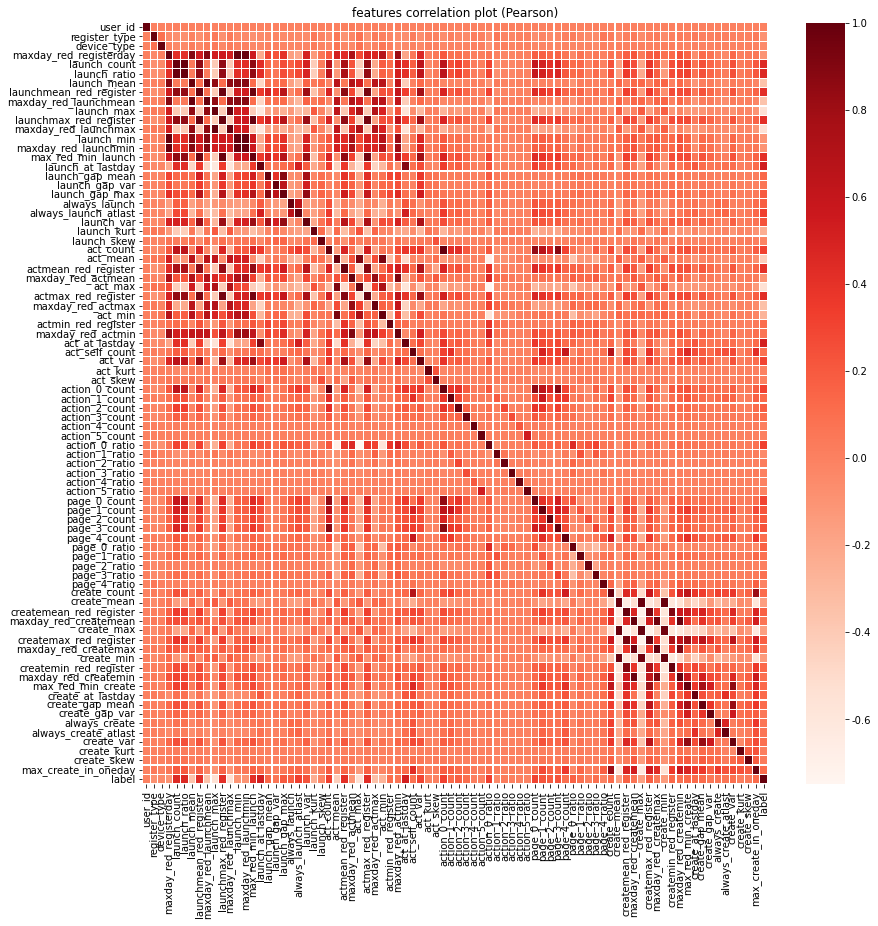

In [74]:
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline 

plt.figure(figsize = (14,14))
plt.title('features correlation plot (Pearson)')
corr = train_x.corr()
sns.heatmap(corr,xticklabels=corr.columns,yticklabels=corr.columns,linewidths=.1,cmap="Reds")
plt.show()

In [75]:
train_x.corr().sort_values('label', ascending=False)

,user_id,register_type,device_type,maxday_red_registerday,launch_count,launch_ratio,launch_mean,launchmean_red_register,maxday_red_launchmean,launch_max,...,create_at_lastday,create_gap_mean,create_gap_var,always_create,always_create_atlast,create_var,create_kurt,create_skew,max_create_in_oneday,label
label,-0.002352,-0.089521,-0.050273,-0.103068,0.452403,0.454985,-0.352544,0.420653,-0.352544,-0.539027,...,0.124030,0.112983,0.049987,0.063626,0.058508,0.094674,0.014773,0.023221,0.114459,1.000000
launch_at_lastday,0.000424,-0.045200,-0.035228,-0.229329,0.426936,0.427217,-0.471225,0.364342,-0.471225,-0.613680,...,0.209922,0.110491,0.055660,0.066199,0.087977,0.099763,0.010884,0.024976,0.116596,0.529378
act_at_lastday,-0.001195,-0.071005,-0.043188,-0.199311,0.407625,0.407570,-0.418935,0.333792,-0.418935,-0.551240,...,0.218998,0.113763,0.058815,0.068581,0.093820,0.103606,0.010129,0.023522,0.121815,0.509457
launch_ratio,0.005829,-0.078934,-0.040049,0.420469,0.992678,1.000000,0.034959,0.845070,0.034959,-0.403145,...,0.081348,0.243743,0.141149,0.075215,0.020540,0.243558,0.027315,0.075299,0.202315,0.454985
launch_count,0.005733,-0.078281,-0.039959,0.431753,1.000000,0.992678,0.043227,0.854371,0.043227,-0.400316,...,0.082576,0.246600,0.144974,0.074304,0.020355,0.249332,0.026859,0.075276,0.202471,0.452403
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
launch_mean,0.005342,-0.005255,0.018186,0.887608,0.043227,0.034959,1.000000,0.093488,1.000000,0.851738,...,-0.111413,0.016948,0.024928,-0.032807,-0.058981,0.033467,0.001174,0.010083,-0.023607,-0.352544
act_mean,0.002567,0.046258,0.069597,0.516243,-0.119250,-0.126287,0.659160,-0.087164,0.659160,0.636104,...,-0.119252,-0.027596,0.002279,-0.056174,-0.063430,-0.006106,-0.004805,0.002181,-0.071126,-0.426976
act_max,-0.001880,0.079441,0.081498,0.269891,-0.422452,-0.425731,0.547063,-0.415080,0.547063,0.719277,...,-0.123866,-0.113825,-0.053483,-0.070147,-0.055734,-0.093032,-0.017781,-0.031435,-0.128435,-0.538072
launch_max,-0.000289,0.038677,0.036847,0.529120,-0.400316,-0.403145,0.851738,-0.410811,0.851738,1.000000,...,-0.129210,-0.103293,-0.050009,-0.054410,-0.054080,-0.087585,-0.013546,-0.026582,-0.104331,-0.539027


In [76]:
train_x[['label']].describe()

,label
count,191121.000000
mean,0.501860
std,0.499998
min,0.000000
25%,0.000000
50%,1.000000
75%,1.000000
max,1.000000


In [77]:
from sklearn import feature_selection

feature_df = train_x[[f for f in train_x.columns if f not in ['user_id','label']]]
label = train_x['label']

# Filter
# 方差选择法，选择方差大于阈值的特征
features_var = feature_selection.VarianceThreshold(threshold=0.7).fit_transform(feature_df)

In [78]:
features_var.shape

(191121, 56)

In [79]:
# Wrapper
# 递归特征消除法，这里选择逻辑回归作为基模型，n_features_to_select为选择的特征个数
from sklearn.linear_model import LogisticRegression
features_rfe = feature_selection.RFE(estimator=LogisticRegression(), n_features_to_select=30).fit_transform(feature_df, label)

In [80]:
# Embedded
# 基于惩罚项的特征选择法,这里选择带L1惩罚项的逻辑回归作为基模型
features_lr_embed = feature_selection.SelectFromModel(LogisticRegression(penalty="l2", C=0.1)).fit_transform(feature_df, label)

# 基于树模型的特征选择法,这里选择GBDT模型作为基模型
from sklearn.ensemble import GradientBoostingClassifier
features_gbdt_embed = feature_selection.SelectFromModel(GradientBoostingClassifier()).fit_transform(feature_df, label)

## 训练模型

In [81]:
del train_x['user_id']
del test_x['user_id']
del train_x['label']

In [82]:
features = train_x.columns.tolist()

In [83]:
def cv_model(clf, train_x, train_y, test_x, clf_name):
    folds = 5
    seed = 2022
    kf = StratifiedKFold(n_splits=folds, shuffle=True, random_state=seed)

    train = np.zeros(train_x.shape[0])
    test = np.zeros(test_x.shape[0])

    cv_scores = []

    for i, (train_index, valid_index) in enumerate(kf.split(train_x, train_y)):
        print('************************************ {} ************************************'.format(str(i+1)))
        trn_x, trn_y, val_x, val_y = train_x.iloc[train_index], train_y[train_index], train_x.iloc[valid_index], train_y[valid_index]

        if clf_name == "lgb":
            train_matrix = clf.Dataset(trn_x, label=trn_y)
            valid_matrix = clf.Dataset(val_x, label=val_y)

            params = {
                'boosting_type': 'gbdt',
                'objective': 'binary',
                'metric': 'auc',
                'min_child_weight': 5,
                'num_leaves': 2 ** 5,
                'lambda_l2': 10,
                'feature_fraction': 0.8,
                'bagging_fraction': 0.8,
                'bagging_freq': 4,
                'learning_rate': 0.5,
                'seed': 2022,
                'n_jobs':-1,
                'verbose': -1,
            }

            model = clf.train(params, train_matrix, 5000, valid_sets=[train_matrix, valid_matrix], 
                              categorical_feature=[], verbose_eval=2000, early_stopping_rounds=500)
            val_pred = model.predict(val_x, num_iteration=model.best_iteration)
            test_pred = model.predict(test_x, num_iteration=model.best_iteration)
            
            print(list(sorted(zip(features, model.feature_importance("gain")), key=lambda x: x[1], reverse=True))[:20])
                
        if clf_name == "xgb":
            train_matrix = clf.DMatrix(trn_x , label=trn_y)
            valid_matrix = clf.DMatrix(val_x , label=val_y)
            test_matrix = clf.DMatrix(test_x)
            
            params = {'booster': 'gbtree',
                      'objective': 'binary:logistic',
                      'eval_metric': 'auc',
                      'gamma': 1,
                      'min_child_weight': 1.5,
                      'max_depth': 5,
                      'lambda': 10,
                      'subsample': 0.7,
                      'colsample_bytree': 0.7,
                      'colsample_bylevel': 0.7,
                      'eta': 0.5,
                      'tree_method': 'exact',
                      'seed': 2022,
                      'nthread': 36
                      }
            
            watchlist = [(train_matrix, 'train'),(valid_matrix, 'eval')]
            
            model = clf.train(params, train_matrix, num_boost_round=50000, evals=watchlist, verbose_eval=2000, early_stopping_rounds=200)
            val_pred  = model.predict(valid_matrix, ntree_limit=model.best_ntree_limit)
            test_pred = model.predict(test_matrix , ntree_limit=model.best_ntree_limit)
                 
        if clf_name == "cat":
            params = {'learning_rate': 0.5, 'depth': 5, 'l2_leaf_reg': 10, 'bootstrap_type': 'Bernoulli',
                      'od_type': 'Iter', 'od_wait': 50, 'random_seed': 11, 'allow_writing_files': False}
            
            model = clf(iterations=2000, **params)
            model.fit(trn_x, trn_y, eval_set=(val_x, val_y),
                      cat_features=[], use_best_model=True, verbose=2000)
            
            val_pred  = model.predict(val_x)
            test_pred = model.predict(test_x)
            
        train[valid_index] = val_pred
        test += test_pred / kf.n_splits
        cv_scores.append(roc_auc_score(val_y, val_pred))
        
        print(cv_scores)
       
    print("%s_scotrainre_list:" % clf_name, cv_scores)
    print("%s_score_mean:" % clf_name, np.mean(cv_scores))
    print("%s_score_std:" % clf_name, np.std(cv_scores))
    return train, test

In [84]:
def lgb_model(x_train, y_train, x_test):
    lgb_train, lgb_test = cv_model(lgb, x_train, y_train, x_test, "lgb")
    return lgb_train, lgb_test

def xgb_model(x_train, y_train, x_test):
    xgb_train, xgb_test = cv_model(xgb, x_train, y_train, x_test, "xgb")
    return xgb_train, xgb_test

def cat_model(x_train, y_train, x_test):
    cat_train, cat_test = cv_model(CatBoostRegressor, x_train, y_train, x_test, "cat") 
    return cat_train, cat_test

In [85]:
lgb_train, lgb_test = lgb_model(train_x, train_y, test_x)

************************************ 1 ************************************
Training until validation scores don't improve for 500 rounds.
[2000]	training's auc: 0.998349	valid_1's auc: 0.968523
Early stopping, best iteration is:
[3101]	training's auc: 0.999404	valid_1's auc: 0.969419
[('act_max', 47614.20706118643), ('launch_max', 23098.36343408376), ('device_type', 22275.404711410403), ('action_0_count', 13059.41190624237), ('launch_ratio', 11758.740526929498), ('page_0_ratio', 6876.477000683546), ('act_count', 6614.204718142748), ('action_0_ratio', 6245.18352894485), ('page_0_count', 6036.210888579488), ('page_3_ratio', 6011.368439659476), ('action_1_ratio', 4900.528861135244), ('act_kurt', 4775.206439748406), ('page_3_count', 4754.852095246315), ('page_2_ratio', 4661.729741305113), ('act_skew', 4529.7787372767925), ('register_type', 4386.768460959196), ('page_1_ratio', 4239.829671002924), ('act_var', 4144.204306975007), ('launch_mean', 4008.0861397236586), ('action_2_ratio', 3933.4

In [ ]:
xgb_train, xgb_test = xgb_model(train_x, train_y, test_x)

************************************ 1 ************************************
[0]	train-auc:0.879988	eval-auc:0.877453
Multiple eval metrics have been passed: 'eval-auc' will be used for early stopping.

Will train until eval-auc hasn't improved in 200 rounds.
[2000]	train-auc:0.993511	eval-auc:0.960941
[4000]	train-auc:0.99711	eval-auc:0.963983
Stopping. Best iteration:
[4406]	train-auc:0.997381	eval-auc:0.96442

[0.9644195590140217]
************************************ 2 ************************************
[0]	train-auc:0.879584	eval-auc:0.877219
Multiple eval metrics have been passed: 'eval-auc' will be used for early stopping.

Will train until eval-auc hasn't improved in 200 rounds.
[2000]	train-auc:0.993278	eval-auc:0.961632
[4000]	train-auc:0.997021	eval-auc:0.965122
Stopping. Best iteration:
[4654]	train-auc:0.997423	eval-auc:0.965801

[0.9644195590140217, 0.9658009385076722]
************************************ 3 ************************************
[0]	train-auc:0.878703	eval-

In [ ]:
cat_train, cat_test = cat_model(train_x, train_y, test_x)

## 模型融合

In [ ]:
def stack_model(oof_1, oof_2, oof_3, predictions_1, predictions_2, predictions_3, y):
   
    train_stack = np.vstack([oof_1, oof_2, oof_3]).transpose()
    test_stack = np.vstack([predictions_1, predictions_2, predictions_3]).transpose()
    
    from sklearn.linear_model import BayesianRidge
    from sklearn.model_selection import RepeatedKFold
    folds = RepeatedKFold(n_splits=5, n_repeats=2, random_state=2022)
    
    oof = np.zeros(train_stack.shape[0])
    predictions = np.zeros(test_stack.shape[0])
    
    for fold_, (trn_idx, val_idx) in enumerate(folds.split(train_stack, y)):
        print("fold n°{}".format(fold_+1))
        trn_data, trn_y = train_stack[trn_idx], y[trn_idx]
        val_data, val_y = train_stack[val_idx], y[val_idx]
        print("-" * 10 + "Stacking " + str(fold_) + "-" * 10)
        clf = BayesianRidge()
        clf.fit(trn_data, trn_y)

        oof[val_idx] = clf.predict(val_data)
        predictions += clf.predict(test_stack) / (5 * 2)
    print('mean: ',roc_auc_score(y, oof))
    
    return oof, predictions

stack_train, stack_test = stack_model(lgb_train, xgb_train, cat_train, lgb_test, xgb_test, cat_test, train_y)